![EU Banner](images/eu_banner.png)

# **0) Catchment Overview**
---

This use case intends to introduce the basic mechanics of the hydrological model [LISFLOOD](https://github.com/ec-jrc/lisflood-code/).
<br>
In this exercise, the objective is to read and visualize some of the static and dynamic maps as well as meteorological forcings required in LISFLOOD. <br>
As we can't discuss all input files in detail, a full list with details can be found [here](https://ec-jrc.github.io/lisflood-code/4_annex_input-files/).

## **0) Input Data**

LISFLOOD contains dozens of input files, more precisely maps that are either static (no time dimension) or dynamic (with time dimension). <br>
Besides, LISFLOODs meteorological inputs will be counted and explored here as a standalone category of the inputs.<br>
In our example model of the Aisén River, all input maps (meteo, static, dynamic) are found in the **`maps`** and **`meteo`** folder.

Meteorological input variables refer to:
* Daily precipitation rates, indicated as **`pr`** or **`tp`** (mm/d)
* Average daily temperature, indicated as **`Tavg`** or **`ta`** (°C)
* Daily potential evaporation rate from free water surface, indicated as **`e`** or **`E0`** (mm/d)
* Daily potential evaporation rate from bare soil, indicated as **`es`** or **`ES0`** (mm/d)
* Daily potential evaporation rate from reference crop, indicated as **`et`** or **`ET0`** (mm/d)

Note, users are thus obliged to provide potential evapotranspiration maps to run the model. <br> 
The preperation of the evapotranspiration maps can be done for example using [LISVAP](https://github.com/ec-jrc/lisflood-lisvap). <br>
As LISVAP uses Penman-Monteith to calculate potential evapotranspiration, additional inputs are required to derive the potential evapotranspiration maps. <br>

***

### **Meteorological Check**
We will now have a look at the temperature, precipitation and evapotranspiration regime of our studz area via Python. <br>
This refers to an important step every modeller should undertake before starting the actual modeling work.<br>
A meteorological check helps the user to get an idea on what to expect hydrologically in terms of general dryness and wetness (aridity), temporal (seasonal) behavior,<br>
but also for plausibility reasons whether annual averages & units are reasonable.

In our example we have one file per variable and year and a prefix *"glofas_"*, e.g. for temperature **`glofas_ta_YYYY`**, where YYYY indicates the specific year.<br>
Besides, as each pixel in LISFLOOD can have fractions of water, bare soil and vegetation we cannot easily get a representative reference evapotranspiration value per Pixel.<br>
We therefore will show the individual water, bare soil and reference crop evapotranspirations individually for the basin scale in comparison to precipitation.

Note: as LISVAP provides the individual reference evapotranspirations for the 3 different land surfaces, the real potential evapotranspiration values that consider land use specific information (e.g.through crop coefficients) are internally computed in LISFLOOD and incorporate additional inputs. 

In [1]:
from pathlib import Path
from datetime import datetime
import pandas as pd

import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

In [2]:
# define paths
path_model = Path('../meteo/meteo_clipped')

# read temp
VAR = "ta"
files = sorted(path_model.glob(f'glofas_{VAR}_*.nc'))
tavg = xr.open_mfdataset(files, combine="by_coords")

# read precip
VAR = "tp"
files = sorted(path_model.glob(f'glofas_{VAR}_*.nc'))
precip = xr.open_mfdataset(files, combine="by_coords")

# read E0 (pot. open water evaporation)
VAR = "e0"
files = sorted(path_model.glob(f'glofas_{VAR}_*.nc'))
e0 = xr.open_mfdataset(files, combine="by_coords")

# read ES0 (pot. soil evaporation)
VAR = "eS0"
files = sorted(path_model.glob(f'glofas_{VAR}_*.nc'))
es0 = xr.open_mfdataset(files, combine="by_coords")

# read ET0 (pot. plant transpiration)
VAR = "eT0"
files = sorted(path_model.glob(f'glofas_{VAR}_*.nc'))
et0 = xr.open_mfdataset(files, combine="by_coords")

Now that all meteorological variables are properly read, we will investigate the basin characteristics further.<br>
However, first we will sum up the individual potential evapotranspiration files to get a total potential evapotranspiration value.

In [3]:
# sum potential evapotranspiration
pet = e0['e0'] + es0['eS0'] + et0['eT0']
# make a ds for consistency
pet = pet.to_dataset(name='pet')


Since timestamps refer to 00:00 (midnight) at the end of the daily time step, for instance 2020-01-01 00:00 represents the end of 31 December 2019.
For aggregation purposes we will shift the timestamp of the variables by 1 day.

In [4]:
pet['time'] = pet['time'] - pd.Timedelta(days=1)
e0['time'] = e0['time'] - pd.Timedelta(days=1)
es0['time'] = es0['time'] - pd.Timedelta(days=1)
et0['time'] = et0['time'] - pd.Timedelta(days=1)
tavg['time'] = tavg['time'] - pd.Timedelta(days=1)
precip['time'] = precip['time'] - pd.Timedelta(days=1)

Now let us have a look at the meteorological variables and what it tells us about the study area.
For this, we first create monthly, annual and seasonal arrays.<br>
First we will check annual average maps of the variables

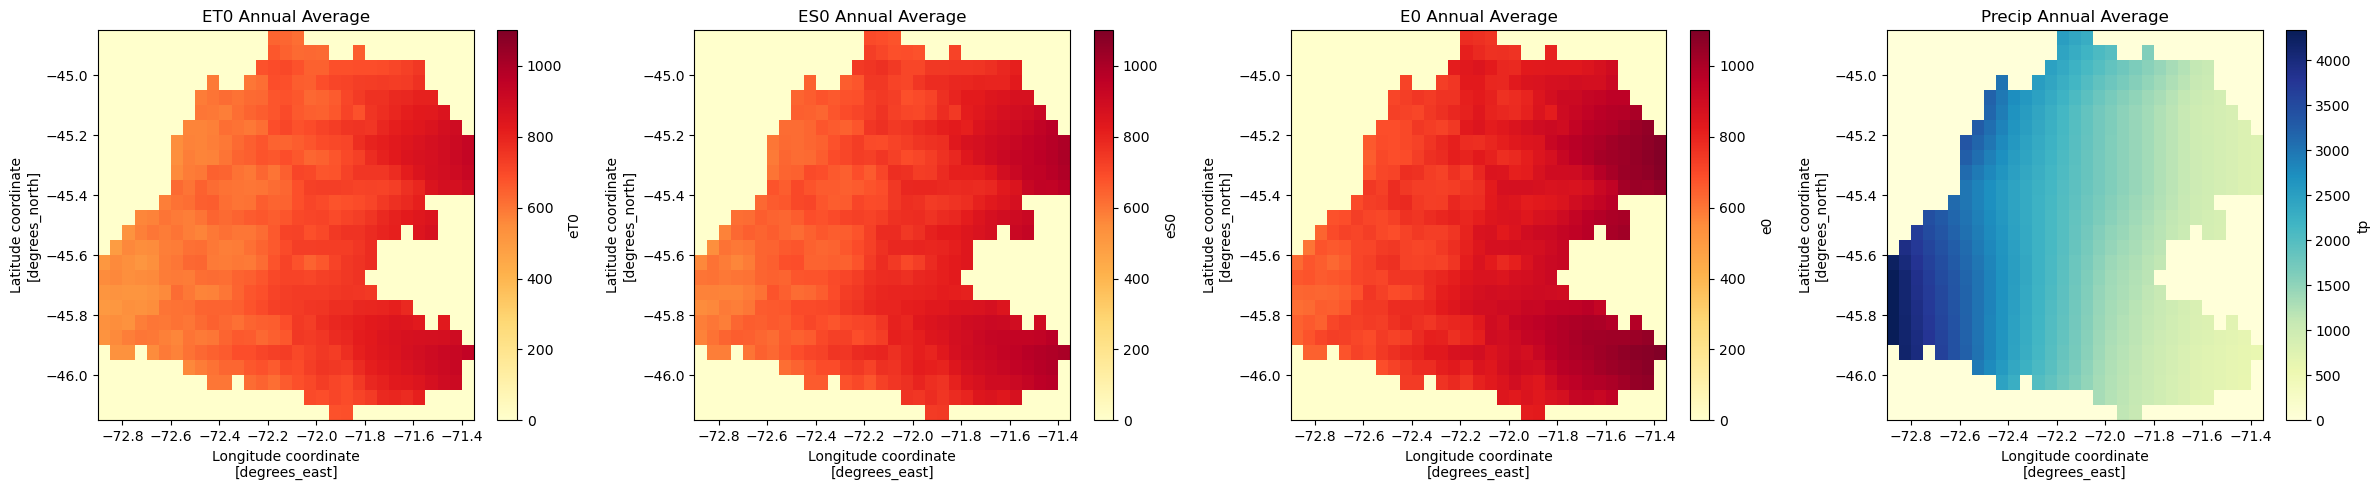

In [5]:
# Annual
pet_a = pet.resample(time='Y').sum()
et0_a = et0.resample(time='Y').sum()
es0_a = es0.resample(time='Y').sum()
e0_a = e0.resample(time='Y').sum()
precip_a = precip.resample(time='Y').sum()
tavg_a = tavg.resample(time='Y').mean()

# Annual Averages
pet_aa = pet_a.mean(dim="time")
et0_aa = et0_a.mean(dim="time")
e0_aa = e0_a.mean(dim="time")
es0_aa = es0_a.mean(dim="time")
precip_aa = precip_a.mean(dim="time")
tavg_aa = tavg_a.mean(dim="time")


# actual figure
fig, axes = plt.subplots(1, 4, figsize=(24, 5))

# ET0 Annual Average
et0_aa['eT0'].plot(ax=axes[0], cmap='YlOrRd', vmin=0,vmax=1100)
axes[0].set_title('ET0 Annual Average')

# ES0 Annual Average
es0_aa['eS0'].plot(ax=axes[1], cmap='YlOrRd', vmin=0,vmax=1100)
axes[1].set_title('ES0 Annual Average')

# E0 Annual Average
e0_aa['e0'].plot(ax=axes[2], cmap='YlOrRd', vmin=0,vmax=1100)
axes[2].set_title('E0 Annual Average')

# Precipitation Annual Average
precip_aa['tp'].plot(ax=axes[3], cmap='YlGnBu')
axes[3].set_title('Precip Annual Average')

fig.tight_layout()



In the annual average plots can see already some precipitation and potential evapotranspiration gradients from West to East. <br>
We also can see that the coastal area in the East are very wet with precipitation values of up 4,000 mm according to out input data.<br>
The 3 different reference evapotranspiration maps indicate that the potential evapotranspiration values are very comparable where (logically) the open water part exceeds the values of the others.

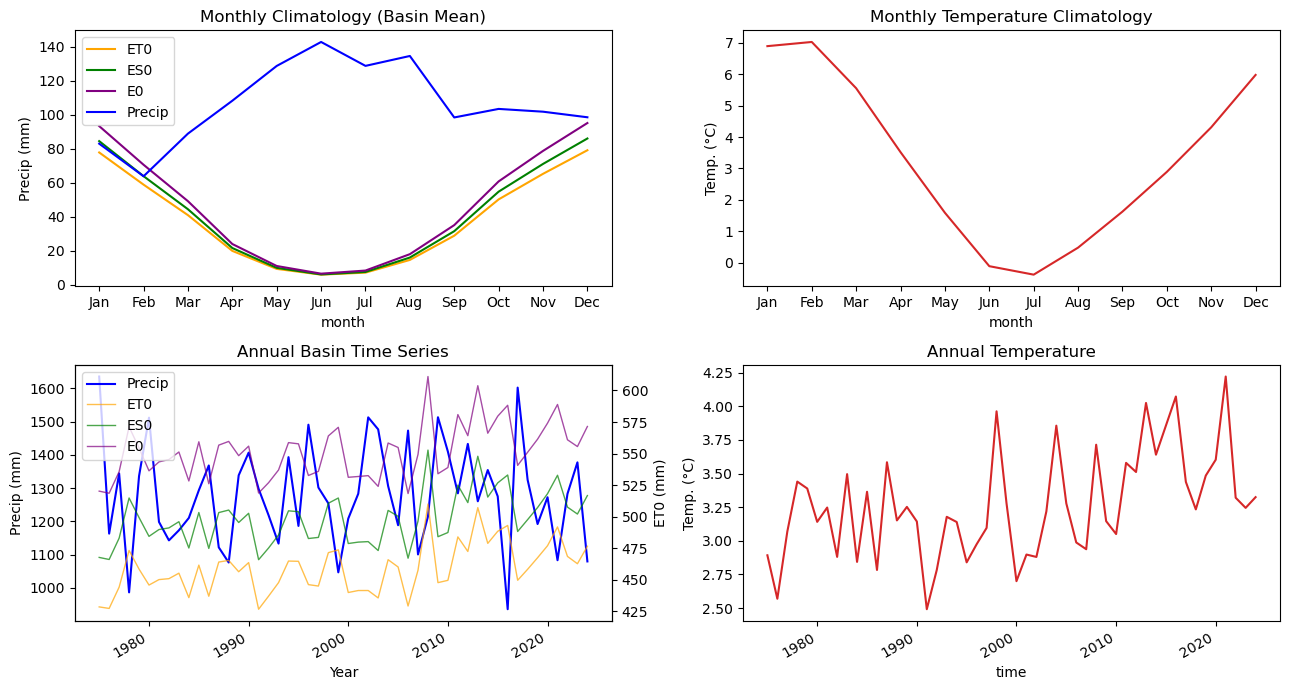

In [6]:
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
          'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# --- Create basin averages ---
et0_basin = et0.mean(dim=["lat", "lon"], skipna=True)['eT0']
es0_basin = es0.mean(dim=["lat", "lon"], skipna=True)['eS0']
e0_basin  = e0.mean(dim=["lat", "lon"], skipna=True)['e0']
precip_basin = precip.mean(dim=["lat", "lon"], skipna=True)['tp']
tavg_basin   = tavg.mean(dim=["lat", "lon"], skipna=True)['ta']

# --- Resample monthly and annual ---
et0_m    = et0_basin.resample(time="MS").sum()
es0_m    = es0_basin.resample(time="MS").sum()
e0_m     = e0_basin.resample(time="MS").sum()
precip_m = precip_basin.resample(time="MS").sum()
tavg_m   = tavg_basin.resample(time="MS").mean()

et0_a    = et0_basin.resample(time="YS").sum()
es0_a    = es0_basin.resample(time="YS").sum()
e0_a     = e0_basin.resample(time="YS").sum()
precip_a = precip_basin.resample(time="YS").sum()
tavg_a   = tavg_basin.resample(time="YS").mean()

# --- Monthly climatology ---
et0_s    = et0_m.groupby("time.month").mean()
es0_s    = es0_m.groupby("time.month").mean()
e0_s     = e0_m.groupby("time.month").mean()
precip_s = precip_m.groupby("time.month").mean()
tavg_s   = tavg_m.groupby("time.month").mean()

# --- Plotting ---
fig, axes = plt.subplots(2, 2, figsize=(13, 7))

# --- Monthly climatology (ET0, ES0, E0 + Precip) ---
et0_s.plot(ax=axes[0,0], label="ET0", color="orange")
es0_s.plot(ax=axes[0,0], label="ES0", color="green")
e0_s.plot(ax=axes[0,0], label="E0", color="purple")
precip_s.plot(ax=axes[0,0], label="Precip", color="b")
axes[0,0].set_title("Monthly Climatology (Basin Mean)")
axes[0,0].set_ylabel("Precip (mm)")
axes[0,0].set_xticks(range(1,13))
axes[0,0].set_xticklabels(months)
axes[0,0].legend()

# Monthly temperature climatology
tavg_s.plot(ax=axes[0,1], color="tab:red")
axes[0,1].set_title("Monthly Temperature Climatology")
axes[0,1].set_ylabel("Temp. (°C)")
axes[0,1].set_xticks(range(1,13))
axes[0,1].set_xticklabels(months)

# --- Annual time series ---
# Precipitation on left axis
precip_a.plot(ax=axes[1,0], label="Precip", color="b",lw=1.5)
axes[1,0].set_title("Annual Basin Time Series")
axes[1,0].set_ylabel("Precip (mm)")
axes[1,0].set_xlabel("Year")

# Create secondary y-axis for ET variables
ax2 = axes[1,0].twinx()
et0_a.plot(ax=ax2, label="ET0", color="orange",lw=1,alpha=0.7)
es0_a.plot(ax=ax2, label="ES0", color="green",lw=1,alpha=0.7)
e0_a.plot(ax=ax2, label="E0", color="purple",lw=1,alpha=0.7)
ax2.set_ylabel("ET0 (mm)")

# Combine legends
lines, labels = axes[1,0].get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc="upper left")

# Annual temperature
tavg_a.plot(ax=axes[1,1], color="tab:red")
axes[1,1].set_title("Annual Temperature")
axes[1,1].set_ylabel("Temp. (°C)")

fig.tight_layout()
